# **Классификация цветов одежды**

Будем иметь дело с реальным набором данных, изображениями высокого разрешения.

Будем применять Transfer Learning


Dataset - Digikala Products Color Classification (Kaggle) [https://www.kaggle.com/datasets/masouduut94/digikala-color-classification]

Как и многие типичные датасеты классификации изображений, он структурирован как папки с фото, где название папки соответствует названию класса. Для таких датасетов можно использовать специальный загрузчик датасетов `torchvision.datasets.ImageFolder`. Он принимает в качестве параметра путь до корневой папки, где лежит датасет. 

In [30]:
from torchvision.datasets import ImageFolder
from torchvision.transforms.v2 import (
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
    RandomPhotometricDistort,
    Compose,
    Resize
)
from torchvision.transforms import ToTensor, Normalize
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch

from ml_dl_experiments import settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Тогда, загрузить уже скачанные данные можно:

In [31]:
path_to_data = settings.SOURCE_PATH + "datasets/digikala"

folder = ImageFolder(path_to_data)

Так как для обучающего и тестового датасета обычно нужны разные предобработки, создаётся класс-обёртка, который позволяет корректно добавить трансформации к существующему датасету. 

In [32]:
from torch.utils.data import Dataset

class TransformDataset(Dataset):
    def __init__(self, dataset, transforms):
        super(TransformDataset, self).__init__()
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return self.transforms(image), label

In [33]:
len(folder)

6239

Разделим данные на тренировочные и тестовые:

In [34]:
train_dataset, val_dataset = random_split(folder, [0.8, 0.2])

len(train_dataset), len(val_dataset)

(4992, 1247)

Пропишем трансформации для набора данных:

In [35]:
train_transforms = Compose([
    RandomHorizontalFlip(p=0.2),
    RandomVerticalFlip(p=0.2),
    RandomRotation([-5, 5], fill=255.),
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.5), (0.5))
])

test_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.5), (0.5))
])

Если есть сомнения в том, как именно обучалась модель и какие ожидаются входные значения, можно ознакомиться с карточкой модели. 

In [36]:
train_data = TransformDataset(train_dataset, train_transforms)
val_data = TransformDataset(val_dataset, test_transforms)

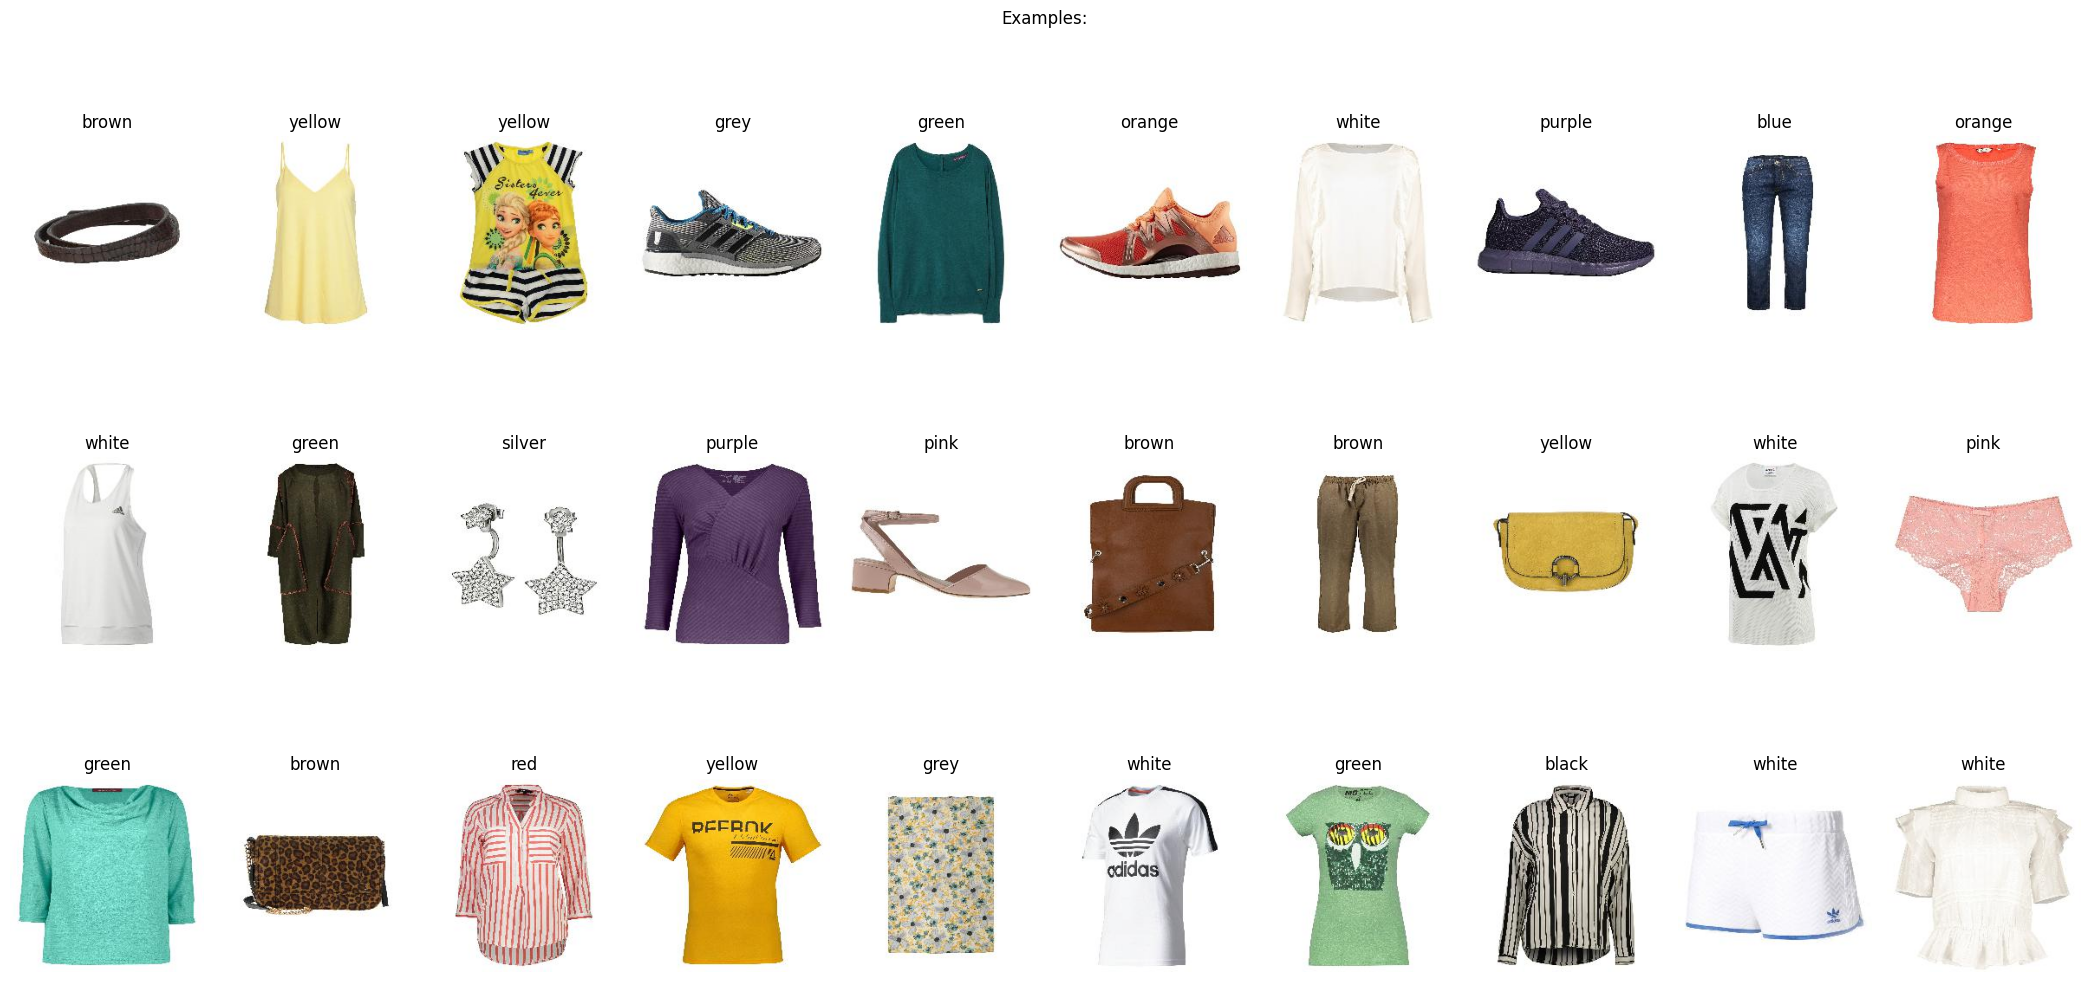

In [37]:
from ml_dl_experiments.dl.dl_modules.CNN import show_examples


show_examples(val_data, 30, classes=folder.classes, denormalize=True)

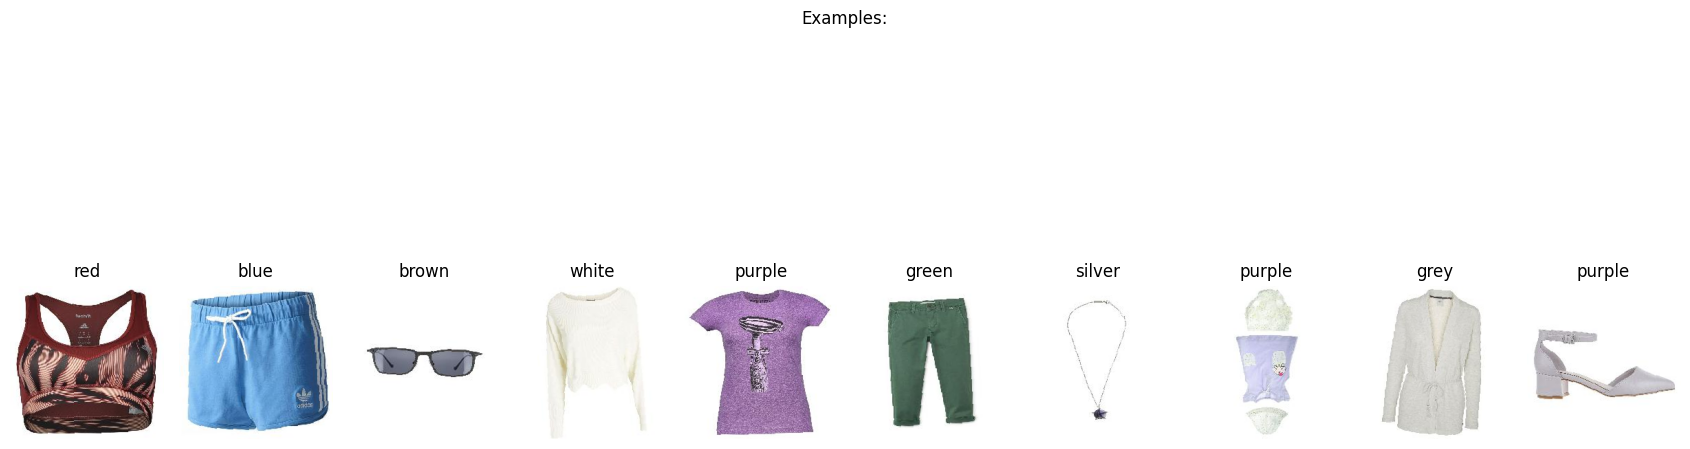

In [38]:
show_examples(train_data, 10, classes=folder.classes, denormalize=True)

Упакуем все в загрузчики данных:

In [39]:
batch_size = 32

In [40]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

## CNN на основе предобученной модели

В качестве предобученной модели используем `MobileNetV3-small`, обученную на весах `ImageNet`. Это лёгкая и маленькая модель, она не требует много аппаратных ресурсов и быстро обучается. 

Загрузить её можно средствами PyTorch. После чего провести стандартный процесс Transfer Learning:

1. Убрать последние слои для классификации на 1000 классов.
   
2. Добавить слои для классификации на 12 классов цветов в датасете.
   
3. Заморозить все слои, кроме добавленных для классификации.
   
4. Провести Fine-tuning, чтобы обучить новые добавленные слои.

In [41]:
from torchvision.models import mobilenet_v3_small
from torchsummary import summary

model = mobilenet_v3_small(weights="IMAGENET1K_V1")
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [42]:
import torch.nn as nn

model.classifier[3] = nn.Linear(
            in_features=1024,
            out_features=12,
            bias=True)

In [43]:
summary(model, (3, 224, 224), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 112, 112]             432
       BatchNorm2d-2         [32, 16, 112, 112]              32
         Hardswish-3         [32, 16, 112, 112]               0
            Conv2d-4           [32, 16, 56, 56]             144
       BatchNorm2d-5           [32, 16, 56, 56]              32
              ReLU-6           [32, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [32, 16, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             136
              ReLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 16, 1, 1]             144
      Hardsigmoid-11             [32, 16, 1, 1]               0
SqueezeExcitation-12           [32, 16, 56, 56]               0
           Conv2d-13           [32, 16, 56, 56]             256
      BatchNorm2d-14           [32, 16,

Заморозим параметры модели

In [44]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True 

In [45]:
summary(model, (3, 224, 224), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 112, 112]             432
       BatchNorm2d-2         [32, 16, 112, 112]              32
         Hardswish-3         [32, 16, 112, 112]               0
            Conv2d-4           [32, 16, 56, 56]             144
       BatchNorm2d-5           [32, 16, 56, 56]              32
              ReLU-6           [32, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [32, 16, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             136
              ReLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 16, 1, 1]             144
      Hardsigmoid-11             [32, 16, 1, 1]               0
SqueezeExcitation-12           [32, 16, 56, 56]               0
           Conv2d-13           [32, 16, 56, 56]             256
      BatchNorm2d-14           [32, 16,

Перейдем к организации дообучения

1. Выбор learning_rate, оптимизатора и функции потерь

In [46]:
learning_rate = 0.001

In [47]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

2. Функция обучения одной эпохи:

In [49]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for batch_index, data in enumerate(train_loader):
        # Извлечение батча
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Обнуление градиентов
        optimizer.zero_grad()
        # Прямое распространение
        outputs = model(inputs)
        # Подсчёт ошибки
        loss = criterion(outputs, labels)
        # Обратное распространение
        loss.backward()
        # Обновление весов
        optimizer.step()

        # Суммирование ошибки за последние 100 батчей
        running_loss += loss.item()
        if batch_index % 20 == 19:
            last_loss = running_loss / 20. # средняя ошибка за 20 батчей
            print(f'Эпоха: {epoch_index}, батч: {batch_index}, ошибка: {round(last_loss, 3)}')
            running_loss = 0.
    
    return last_loss

In [50]:
EPOCHS: int = 20
best_vloss = 0.7

for epoch in range(EPOCHS):
    print(f'Эпоха {epoch}')
    # Перевод модели в режим обучения 
    model.train()
    # Эпоха обучения
    avg_loss = train_one_epoch(epoch)
    # Перевод модели в режим оценки / валидации
    model.eval()
    running_vloss = 0.0

    # Валидация
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
    
    avg_vloss = running_vloss / (len(val_loader) + 1)

    # Сохранение лучше по качеству модели
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'models/color_fash_classifier_epoch_{epoch}.pt'
        torch.save(model.state_dict(), model_path)

    print(f'В конце эпохи ошибка train {avg_loss}, ошибка val {avg_vloss}') 

Эпоха 0
Эпоха: 0, батч: 19, ошибка: 1.929
Эпоха: 0, батч: 39, ошибка: 1.382
Эпоха: 0, батч: 59, ошибка: 1.254
Эпоха: 0, батч: 79, ошибка: 1.072
Эпоха: 0, батч: 99, ошибка: 1.184
Эпоха: 0, батч: 119, ошибка: 1.015
Эпоха: 0, батч: 139, ошибка: 1.027
В конце эпохи ошибка train 1.0267873257398605, ошибка val 1.2209627628326416
Эпоха 1
Эпоха: 1, батч: 19, ошибка: 0.878
Эпоха: 1, батч: 39, ошибка: 0.977
Эпоха: 1, батч: 59, ошибка: 0.983
Эпоха: 1, батч: 79, ошибка: 0.933
Эпоха: 1, батч: 99, ошибка: 0.989
Эпоха: 1, батч: 119, ошибка: 0.938
Эпоха: 1, батч: 139, ошибка: 1.013
В конце эпохи ошибка train 1.0129565685987472, ошибка val 0.9528844952583313
Эпоха 2
Эпоха: 2, батч: 19, ошибка: 0.839
Эпоха: 2, батч: 39, ошибка: 0.888
Эпоха: 2, батч: 59, ошибка: 0.811
Эпоха: 2, батч: 79, ошибка: 0.81
Эпоха: 2, батч: 99, ошибка: 0.88
Эпоха: 2, батч: 119, ошибка: 0.804
Эпоха: 2, батч: 139, ошибка: 0.919
В конце эпохи ошибка train 0.9189304679632186, ошибка val 0.9076371192932129
Эпоха 3
Эпоха: 3, батч: 19,

In [51]:
model_path = f'models/color_fash_classifier_epoch_40.pt'
torch.save(model.state_dict(), model_path)

Оценим инференс

In [52]:
from sklearn.metrics import classification_report
labels_predicted = []
labels_true = []

model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        img, labels = images.to(device), labels.to(device)

        outputs = model(img)
        _, predicted = torch.max(outputs, 1) # argmax по всем примерам
        labels_predicted.extend(predicted.cpu().numpy())
        labels_true.extend(labels.cpu().numpy())

print(classification_report(labels_true, labels_predicted, target_names=folder.classes))

              precision    recall  f1-score   support

       black       0.61      0.68      0.64        65
        blue       0.90      0.67      0.77       143
       brown       0.73      0.73      0.73       142
       green       0.72      0.65      0.68       143
        grey       0.51      0.77      0.61       120
      orange       0.66      0.46      0.55        71
        pink       0.56      0.60      0.58        60
      purple       0.65      0.54      0.59        79
         red       0.78      0.86      0.82       147
      silver       0.67      0.72      0.69        61
       white       0.78      0.76      0.77       127
      yellow       0.85      0.78      0.81        89

    accuracy                           0.70      1247
   macro avg       0.70      0.69      0.69      1247
weighted avg       0.72      0.70      0.71      1247



Из очевидных выводов - не сохранившийся тут процесс обучения, когда мы заменяем весь model.classifier на один линейный слой 576 -> 12 мы получаем метрику около 80%. Сейчас, я заменил только последний слой и его дообучаю. И модель явно начала переобучаться после лосса 0.5 на трейне.

Для данного набора данных интересно, все-таки какие решения предпринять, чтобы достичь обучения с хорошей метрикой.